In [8]:
%%capture
!pip install pytorch-lightning
!pip install lightning-bolts

# Data preparation

In [15]:
from torchvision import models
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, Subset
from torch.optim import Adam
from torch.nn.functional import cross_entropy

from google.colab import drive
drive.mount('/content/drive')


import pytorch_lightning as pl
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#1. Basic
tr1 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#2. Crop
tr2 = transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop((224,224)),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#3. Affine
tr3 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.RandomAffine(degrees=90, shear=20, scale=[0.8, 1.2]),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#4. Horizontal flip
tr4 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.RandomHorizontalFlip(p=1),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#5. Vertical flip
tr5 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.RandomVerticalFlip(p=1),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])


#6. ColorJitter
tr6 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#7. Mix
tr7 = transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop((224,224)),
             transforms.RandomAffine(degrees=90, shear=20, scale=[0.8, 1.2]),
             transforms.RandomHorizontalFlip(p=1),
             transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])

#8. Mix2
tr8 = transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop((224,224)),
             transforms.RandomAffine(degrees=90, shear=20, scale=[0.8, 1.2]),
             transforms.RandomHorizontalFlip(p=0.8),
             transforms.RandomVerticalFlip(p=0.8),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])


#9. Mix3
tr9 = transforms.Compose(
            [transforms.Resize((256,256)),
             transforms.RandomCrop((224,224)),
             transforms.RandomAffine(degrees=90, shear=20, scale=[0.8, 1.2]),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])


#10. Mix4
tr10 = transforms.Compose(
            [transforms.Resize((224,224)),
             transforms.RandomAffine(degrees=90, shear=20, scale=[0.8, 1.2]),
             transforms.RandomHorizontalFlip(p=0.8),
             transforms.RandomVerticalFlip(p=0.8),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
             ])


trs = {'Basic': tr1, 'Crop':tr2, 'Affine':tr3, 'HFlip':tr4, 'VFlip':tr5, 'Color':tr6, 'Mix':tr7, 'Mix2':tr8, 'Mix3':tr9, 'Mix4':tr10 }
tr_keys = list(trs.keys())

seeds = [77777, 123, 2646, 3625, 12, 59, 411]

def train_val_loader(data_dir, key, seed = 77777):
  #parameters
  data_dir =  '/content/drive/MyDrive/NN/datasets'
  train_ratio=0.77
  seed = seed
  
  #transforms
  train_transform = trs[key]
  val_transform = transforms.Compose(
              [transforms.Resize((224,224)),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
              ])

  #load data
  data_full = torchvision.datasets.ImageFolder(root=data_dir,  transform=train_transform)
  train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=train_transform)
  val_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=val_transform)
  
  
  #split dataset
  num_samples = len(train_dataset)
  idxs = list(range(num_samples))
  split = int(train_ratio*num_samples)
  np.random.seed(seed)
  np.random.shuffle(idxs)
  train_idx, valid_idx = idxs[:split], idxs[split:]

  #Assign train, val, test dataset for use in dataloaders
  data_train = Subset(train_dataset, train_idx)
  data_val =  Subset(val_dataset, valid_idx)

  #data loaders
  train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
  val_loader = DataLoader(data_val, batch_size=20, shuffle=False)
  return train_loader, val_loader

In [11]:
#data loaders for Basic images
data_dir =  '/content/drive/MyDrive/NN/datasets'
train_loader, val_loader = train_val_loader(data_dir, 'Basic')

for batch in train_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([16, 3, 224, 224]) torch.Size([16])


#Pretrained SwAV

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pl_bolts.models.self_supervised import SwAV

weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/swav/bolts_swav_imagenet/swav_imagenet.ckpt'
swav = SwAV.load_from_checkpoint(weight_path, strict=False, nmb_prototypes=3000)

class SSLImageClassifier(pl.LightningModule):
  def __init__(self, num_classes=3, lr=1e-3):
    super().__init__()
    self.save_hyperparameters()

    self.backbone = swav.model #pretrained model
    self.finetune_layer = torch.nn.Linear(3000, num_classes)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    if self.trainer.current_epoch < 10:
      with torch.no_grad():
        (f1, f2)= self.backbone(x)
        features = f2
    
    else:
      (f1, f2)= self.backbone(x)
      features = f2

    preds = self.finetune_layer(features)
    loss = cross_entropy(preds, y)
    self.log('train_loss', loss)
    self.log('train_acc', accuracy(preds, y))
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    (f1, f2)= self.backbone(x)
    features = f2
    
    preds = self.finetune_layer(features)
    loss = cross_entropy(preds, y)
    self.log('val_loss', loss)
    self.log('val_acc', accuracy(preds, y))
    return loss

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.hparams.lr)
    return optimizer

ModuleNotFoundError: ignored

In [ ]:
#parameter
data_dir =  '/content/drive/MyDrive/NN/datasets'
save_dir_path = "/content/drive/MyDrive/save_model"

trs = {#'Basic': tr1,
      #  'Crop':tr2,
      #  'Affine':tr3,
      #  'HFlip':tr4,
      #  'VFlip':tr5,
      #  'Color':tr6,
      #  'Mix':tr7,
      #  'Mix2':tr8,
      #  'Mix3':tr9,
       'Mix4':tr10,
       }
tr_keys = list(trs.keys())


In [ ]:
tr_keys

['Mix4']

In [ ]:
seeds

[77777, 123, 2646, 3625, 12, 59, 411]

In [13]:
from torch.serialization import check_module_version_greater_or_equal
from pytorch_lightning.callbacks import ModelCheckpoint

for seed in seeds:
  for key in tr_keys:
    num_epoch = 50
    print('SaAV')
    print('SEED: ', seed)
    print('TRANSFORMS: ', key)

    max_epoch = num_epoch
    val_check_epoch = max_epoch//5
    print('max_epochs: ', max_epoch)
    print('val_epochs: ', val_check_epoch)

    #transformed dataloader
    train_loader, val_loader = train_val_loader(data_dir, key, seed)

    #model
    ssl_classifier = SSLImageClassifier(lr=1e-3)

    #callback
    checkpoint_callback = ModelCheckpoint(dirpath=save_dir_path, monitor="val_acc", mode='max', 
                                          save_weights_only= True,
                                          filename=f"SwAV-seed-{seed}")

    #log
    logger = pl.loggers.TensorBoardLogger(name=f'SwAV-{key}-{seed}', save_dir='lightning_logs')

    #train
    trainer = pl.Trainer(progress_bar_refresh_rate=4,
                                gpus=1,
                                max_epochs = max_epoch,
                                callbacks=checkpoint_callback, 
                                logger = logger,
                                log_every_n_steps=4
                                )

    trainer.fit(ssl_classifier, train_loader, val_loader)
    trainer.save_checkpoint(f"example-{seed}.ckpt")

SaAV
SEED:  77777
TRANSFORMS:  Basic
max_epochs:  50
val_epochs:  10


NameError: ignored

# Discussion

In [ ]:
#test loader
data_dir =  '/content/drive/MyDrive/NN/datasets'
test_transforms =transforms.Compose(
                                    [transforms.Resize(300),
                                    transforms.RandomCrop(224),
                                    transforms.RandomHorizontalFlip(p=0.8),
                                    transforms.RandomVerticalFlip(p=0.8),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])


def make_test_loader(data_dir, transforms):
  data_test = torchvision.datasets.ImageFolder(root=data_dir, transform=transforms)
  test_loader = DataLoader(data_test, batch_size=84, shuffle=False)
  return test_loader

test_loader = make_test_loader(data_dir, test_transforms)

# SwAV evaluation

In [ ]:
#load saved my SwAV model
ssl_classifier = SSLImageClassifier(lr=1e-3)
model_path = '/content/drive/MyDrive/save_model/SwAV-seed-411.ckpt'
mymodel = ssl_classifier.load_from_checkpoint(model_path, strict=False, nmb_prototypes=3000)
mymodel.eval()
mymodel.freeze()

In [ ]:
def SwAV_extract_xyz(dataloader):
  #img features
  feats = []
  labels = []
  imgs = []

  #train
  for batch in dataloader:
    x, y = batch
    (f1, f2) = mymodel.backbone(x)
    feats.append(f2)
    imgs.append(x)
    labels.append(y)

  #concatanate training batch
  zs = feats[0]
  ys = labels[0]
  xs = imgs[0]

  for idx in range(1, len(feats)):
    zs = torch.cat((zs, feats[idx]))
    ys = torch.cat((ys, labels[idx]))
    xs = torch.cat((xs, imgs[idx]))
    print(zs.shape, ys.shape)
  return xs, ys, zs

In [ ]:
xs_train, ys_train, zs_train = SwAV_extract_xyz(train_loader)
xs_test, ys_test, zs_test = SwAV_extract_xyz(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([32, 3000]) torch.Size([32])
torch.Size([48, 3000]) torch.Size([48])
torch.Size([64, 3000]) torch.Size([64])


In [ ]:
ys_train

tensor([1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 1,
        0, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
        2, 0, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 0])

For the test data

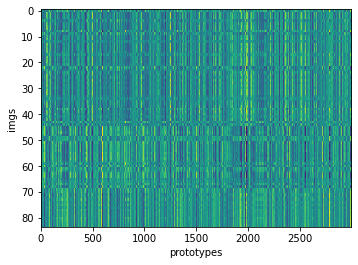

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#visualise cluster assignment by imgs
plt.imshow(zs_test.numpy(), interpolation='nearest', aspect=25)
plt.xlabel('prototypes')
plt.ylabel('imgs')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


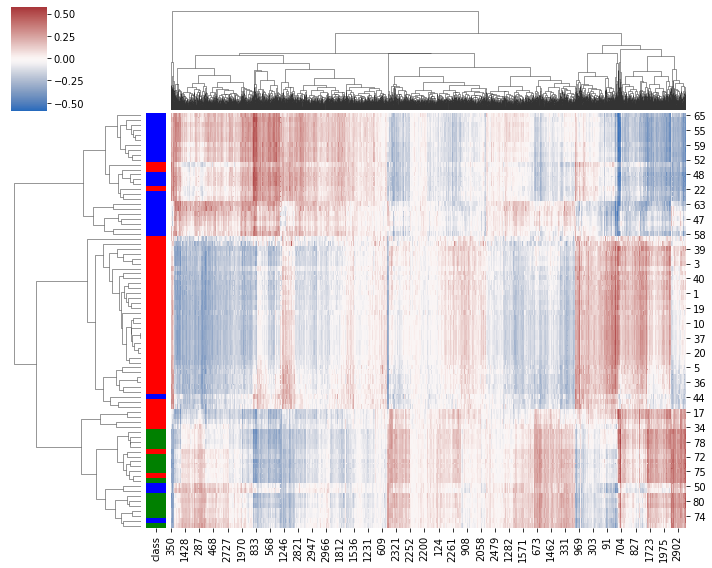

In [ ]:
#clustering map (test loader)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.DataFrame(zs_test.numpy())
target = pd.Series(ys_test, name='class')
lut = dict(zip(np.unique(ys_test.numpy()), "rbg"))
row_colors = target.map(lut)

sns.clustermap(df1, cmap="vlag", figsize=(10,8), row_colors=row_colors)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


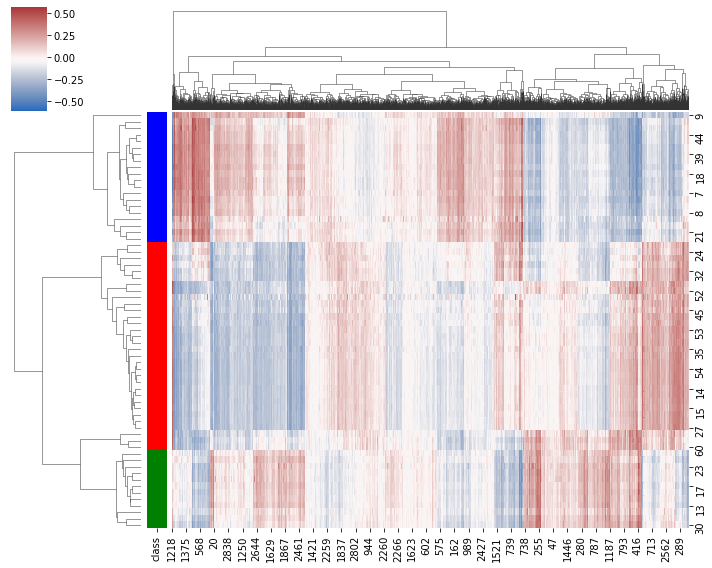

In [ ]:
#clustering map (train loader)
df2 = pd.DataFrame(zs_train.numpy())
target = pd.Series(ys_train, name='class')
lut = dict(zip(np.unique(ys_train.numpy()), "rbg"))
row_colors = target.map(lut)

sns.clustermap(df2, cmap="vlag", figsize=(10,8), row_colors=row_colors)

In [ ]:
#cost
preds_test = mymodel.finetune_layer(zs_test)

#loss
loss_test = cross_entropy(preds_test, ys_test)

#accuracy
acc_test = accuracy(preds_test, ys_test)

#class
pred_test_class = torch.argmax(preds_test, dim=1)

pred_test_class, acc_test, loss_test

(tensor([2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
         1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), tensor(0.8810), tensor(0.3479))

In [ ]:
def store_misclass_info(imgs, preds, truths):
  miss_idx = []
  miss_img = []
  miss_label = []
  true_label = []

  for idx in range(len(preds)):
    if preds[idx] != truths[idx]:
      miss_idx.append(idx)
      miss_img.append(imgs[idx].permute(1,2,0))
      miss_label.append(preds[idx])
      true_label.append(truths[idx])
  return miss_idx, miss_img, miss_label, true_label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

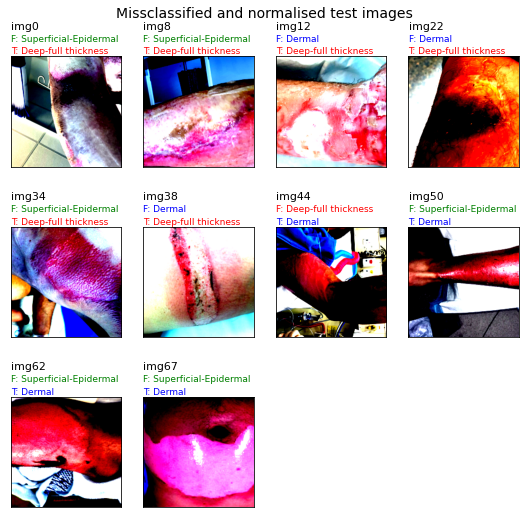

In [ ]:
#visualise missclassify img
import matplotlib.pyplot as plt

class_names = ('Deep-full thickness', 'Dermal', 'Superficial-Epidermal')
colors ='rbg'
miss_idx, miss_img, miss_label, true_label = store_misclass_info(xs_test, pred_test_class, ys_test)

miss_num = len(miss_idx)
n_col = miss_num//3 + 1
n_row = miss_num//n_col +1

def plot_gallery(images=miss_img, miss_label=miss_label, n_row=n_row, n_col=n_col):
  if miss_img != []:
    plt.figure(figsize=(1.8*n_col, 2.4*n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35) #adjust layout parameters
    plt.suptitle('Missclassified and normalised test images', fontsize=14)
    for i in range(miss_num):
      plt.subplot(n_row, n_col,  i+1)
      plt.imshow(images[i])
      plt.text(0,-55, f"img{miss_idx[i]}", size=11)
      plt.text(0,-30, f"F: {class_names[miss_label[i]]}", size=9, color=colors[miss_label[i]])
      plt.text(0,-5, f"T: {class_names[true_label[i]]}", size=9, color=colors[true_label[i]])
      plt.xticks(())
      plt.yticks(())
  else:
    pass

plot_gallery()
plt.show()

In [ ]:
#rawdata loader
data_dir =  '/content/drive/MyDrive/NN/datasets'
raw_transforms =transforms.Compose(
                                    [transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    ])

data_raw = torchvision.datasets.ImageFolder(root=data_dir,  transform=raw_transforms)
raw_loader = DataLoader(data_raw, batch_size=84, shuffle=False)
raw_imgs = []

for batch in raw_loader:
  x, y = batch
  raw_imgs.append(x)

In [ ]:
raw_imgs = []
for batch in raw_loader:
  x, y = batch
  raw_imgs.append(x)

raw_imgs = raw_imgs[0]

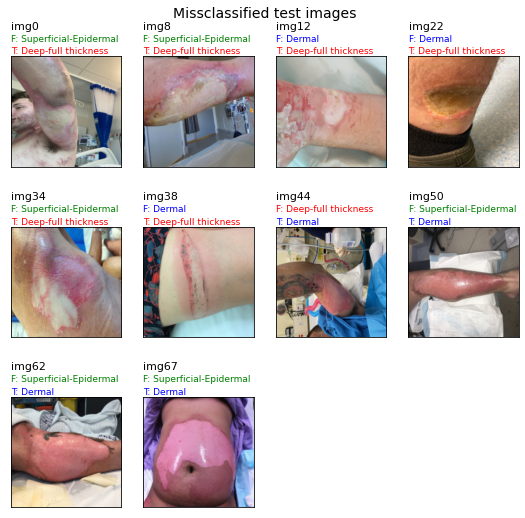

In [ ]:
plt.figure(figsize=(1.8*n_col, 2.4*n_row))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.9, hspace=0.35) #adjust layout parameters
plt.suptitle('Missclassified test images', fontsize=14)
for i in range(len(miss_idx)):
    plt.subplot(n_row, n_col,  i+1)
    plt.imshow(raw_imgs[miss_idx[i]].permute(1,2,0))
    plt.text(0,-55, f"img{miss_idx[i]}", size=11)
    plt.text(0,-30, f"F: {class_names[miss_label[i]]}", size=9, color=colors[miss_label[i]])
    plt.text(0,-5, f"T: {class_names[true_label[i]]}", size=9, color=colors[true_label[i]])
    plt.xticks(())
    plt.yticks(())

plt.show()

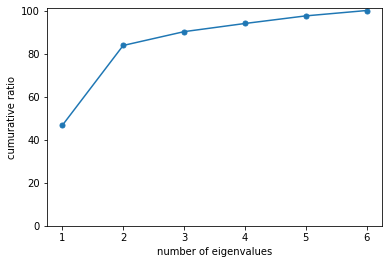

In [ ]:
#Principal component analysis
u, s, v = torch.pca_lowrank(zs_test, q=None, center=True, niter=2)

#cumurative distribution
eig_ratio = s/torch.sum(s)
eig_cumsum = torch.cumsum(eig_ratio, dim=0)*100
num_eig = len(eig_ratio)
X = np.arange(1, num_eig+1)

#Visualization
import matplotlib.pyplot as plt
plt.plot(X, eig_cumsum, marker='.', markersize=10)
plt.xlabel('number of eigenvalues')
plt.ylabel('cumurative ratio')
plt.ylim(0,101)
plt.show()

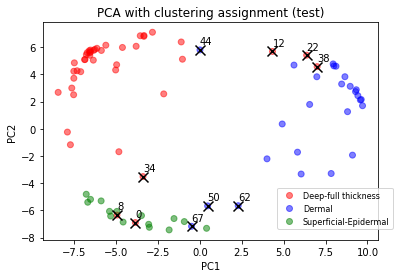

In [ ]:
#Visualise PC map for test data
PCs = torch.matmul(zs_test, v[:, :2])
X = PCs[:, 0]
Y = PCs[:, 1]

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class_names = ('Deep-full thickness', 'Dermal', 'Superficial-Epidermal')
colormap = ListedColormap(['r','b','g'])

scatter = plt.scatter(X, Y, c=ys_test, alpha=0.5, cmap=colormap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with clustering assignment (test)')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names, loc=(0.7, 0.05), fontsize = '8')

for idx in miss_idx:
   plt.scatter(X[idx], Y[idx], marker='x', s = 100, color = 'k')
   plt.text(X[idx], Y[idx]+0.4, idx)

plt.show()

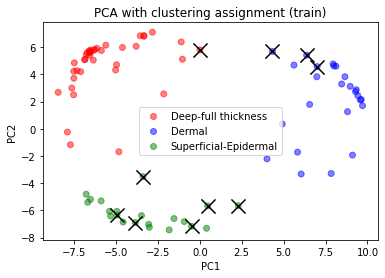

In [ ]:
#Visualise PC map for train
PCs = torch.matmul(zs_test, v[:, :2])
X = PCs[:, 0]
Y = PCs[:, 1]

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class_names = ('Deep-full thickness', 'Dermal', 'Superficial-Epidermal')
colormap = ListedColormap(['r','b','g'])

scatter = plt.scatter(X, Y, c=pred_test_class, alpha=0.5, cmap=colormap)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with clustering assignment (train)')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)

for idx in miss_idx:
   plt.scatter(X[idx], Y[idx], marker='x', s = 200, color = 'k')

plt.show()

# Test Accuracy Comparison

In [ ]:
#test
def test_performance(mymodel, num_test):
  #model weight fixed
  mymodel.eval()
  mymodel.freeze()

  Accuracies = []
  Losses = []

  data_dir =  '/content/drive/MyDrive/NN/datasets'
  test_transforms =transforms.Compose(
                                      [transforms.Resize((300)),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.8),
                                      transforms.RandomVerticalFlip(p=0.8),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      ])

  for _ in range(num_test):
    test_loader = make_test_loader(data_dir, test_transforms)

    feats = []
    labels = []
    
    for batch in test_loader:
      x, y = batch
      (f1, f2) = mymodel.backbone(x)
      feats.append(f2)
      labels.append(y)
      
    #concatanate training batch
    zs = feats[0]
    ys = labels[0]
    for idx in range(1, len(feats)):
      zs = torch.cat((zs, feats[idx]))
      ys = torch.cat((ys, labels[idx]))

    #store loss and accuracy
    preds = mymodel.finetune_layer(zs)
    loss = cross_entropy(preds, ys)
    acc = accuracy(preds, ys)

    Accuracies.append(acc)
    Losses.append(loss)
  return Accuracies, Losses

In [ ]:
accSwAV, lossSwAV = test_performance(mymodel, 100)

In [ ]:
#count misclassed image with test set
def test_misclass(mymodel, num_test):
  #model weight fixed
  mymodel.eval()
  mymodel.freeze()

  missclass_idxs = []
  missclass_labels = []
  true_labels = []

  data_dir =  '/content/drive/MyDrive/NN/datasets'
  test_transforms =transforms.Compose(
                                      [transforms.Resize((300)),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.8),
                                      transforms.RandomVerticalFlip(p=0.8),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      ])

  for _ in range(num_test):
    test_loader = make_test_loader(data_dir, test_transforms)

    feats = []
    labels = []
    
    for batch in test_loader:
      x, y = batch
      (f1, f2) = mymodel.backbone(x)
      feats.append(f2)
      labels.append(y)
      
    #concatanate training batch
    zs = feats[0]
    ys = labels[0]
    for idx in range(1, len(feats)):
      zs = torch.cat((zs, feats[idx]))
      ys = torch.cat((ys, labels[idx]))

    #store idx and labels
    preds = mymodel.finetune_layer(zs)
    preds = torch.argmax(preds, dim=1)

    for idx in range(len(preds)):
      if preds[idx] != ys[idx]:
        missclass_idxs.append(idx)
        missclass_labels.append(preds[idx])
        true_labels.append(ys[idx])

  return missclass_idxs, missclass_labels, true_labels

missclass_idxs, missclass_labels, true_labels = test_misclass(mymodel, 50)

In [ ]:
import numpy as np
idx, count = np.unique(missclass_idxs, return_counts = True)
idx, count

rates = count /50 *100

In [ ]:
dict_miss_img = {}

for i in range(len(idx)):
  dict_miss_img[idx[i]] = rates[i]

dict_miss_img

{0: 100.0,
 3: 12.0,
 4: 10.0,
 7: 2.0,
 8: 62.0,
 12: 46.0,
 17: 32.0,
 18: 8.0,
 19: 10.0,
 21: 2.0,
 22: 34.0,
 28: 6.0,
 30: 10.0,
 31: 10.0,
 34: 22.0,
 35: 6.0,
 36: 2.0,
 38: 56.00000000000001,
 40: 32.0,
 41: 6.0,
 43: 28.000000000000004,
 44: 82.0,
 47: 44.0,
 48: 2.0,
 49: 38.0,
 50: 60.0,
 52: 2.0,
 53: 8.0,
 56: 2.0,
 58: 8.0,
 60: 24.0,
 61: 24.0,
 62: 84.0,
 63: 16.0,
 65: 12.0,
 66: 24.0,
 67: 78.0,
 69: 6.0,
 72: 6.0,
 73: 2.0,
 78: 8.0}

In [ ]:
sort = sorted(dict_miss_img.items(), key=lambda item: item[1], reverse=True)

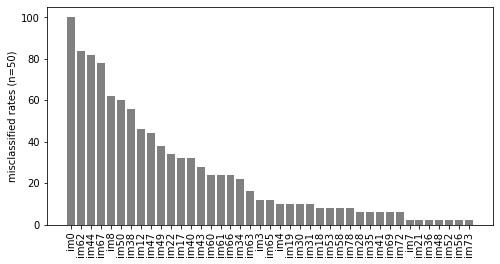

In [ ]:
imgs = []
rates = []

for pair in sort:
  key, value = pair
  imgs.append(f'im{key}')
  rates.append(value)

X = np.arange(len(imgs))

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(X, rates, color='grey')
plt.xticks(X, imgs, rotation=90)
plt.ylabel('misclassified rates (n=50)')

plt.show()

# ResNet50

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy

class SupervisedImageClassifier(pl.LightningModule):
  def __init__(self, num_classes=3, lr=1e-3):
    super().__init__()
    self.save_hyperparameters()

    self.backbone = models.resnet50(pretrained=True)
    self.finetune_layer = torch.nn.Linear(self.backbone.fc.out_features, num_classes)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    if self.trainer.current_epoch < 10:
      with torch.no_grad():
        features = self.backbone(x)
    
    else:
      features = self.backbone(x)
    
    preds = self.finetune_layer(features)
    loss = cross_entropy(preds, y)
    self.log('train_loss', loss, on_step=False, on_epoch=True)
    self.log('train_acc', accuracy(preds, y), on_step=False, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch

    features = self.backbone(x)
    
    preds = self.finetune_layer(features)
    loss = cross_entropy(preds, y)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(preds, y), on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = Adam(self.parameters(), lr=self.hparams.lr)
    return optimizer

In [ ]:
#load saved my ResNet50 model
sl_classifier = SupervisedImageClassifier(lr=1e-3)
model_path = '/content/drive/MyDrive/save_model/ResNet50-seed-411.ckpt'
mymodel50 = sl_classifier.load_from_checkpoint(model_path, strict=False)
mymodel50.eval()
mymodel50.freeze()

In [ ]:
#test
def test_performance_ResNet50(mymodel50, num_test):
  #model weight fixed
  mymodel50.eval()
  mymodel50.freeze()

  Accuracies = []
  Losses = []

  data_dir =  '/content/drive/MyDrive/NN/datasets'
  test_transforms =transforms.Compose(
                                      [transforms.Resize((300)),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.8),
                                      transforms.RandomVerticalFlip(p=0.8),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                      ])

  for _ in range(num_test):
    test_loader = make_test_loader(data_dir, test_transforms)

    feats = []
    labels = []
    
    for batch in test_loader:
      x, y = batch
      f2 = mymodel50.backbone(x)
      feats.append(f2)
      labels.append(y)
      
    #concatanate training batch
    zs = feats[0]
    ys = labels[0]
    for idx in range(1, len(feats)):
      zs = torch.cat((zs, feats[idx]))
      ys = torch.cat((ys, labels[idx]))

    #store loss and accuracy
    preds = mymodel50.finetune_layer(zs)
    loss = cross_entropy(preds, ys)
    acc = accuracy(preds, ys)

    Accuracies.append(acc)
    Losses.append(loss)
  return Accuracies, Losses

In [ ]:
acc50, loss50 = test_performance_ResNet50(mymodel50, 100)

In [ ]:
data = [accSwAV, acc50]

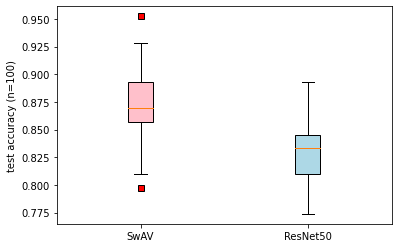

In [ ]:
#compare test accuracy between the two models
import matplotlib.pyplot as plt

red_square = dict(markerfacecolor='r', marker='s')
box = plt.boxplot(data, flierprops=red_square, patch_artist=True)

colors = ['pink', 'lightblue']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('test accuracy (n=100)')
plt.xticks([1, 2], ['SwAV', 'ResNet50'])
plt.show()

In [ ]:
sum(accSwAV)/100, sum(acc50)/100

(tensor(0.8717), tensor(0.8277))

In [ ]:
data = {'SwAV': accSwAV,
        'ResNet50': acc50}


from scipy import stats
stats.ttest_ind(accSwAV, acc50)

Ttest_indResult(statistic=12.117286934309238, pvalue=1.2097574306773799e-25)

In [ ]:
min(accSwAV), max(accSwAV)

(tensor(0.7976), tensor(0.9524))

In [ ]:
min(acc50), max(acc50)

(tensor(0.7738), tensor(0.8929))

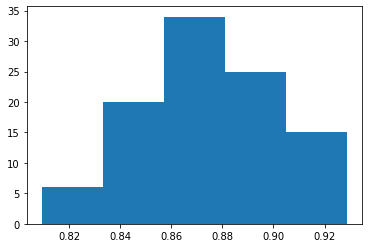

In [ ]:
plt.hist(acc, bins = 5)
plt.show()

# ResNet50 Evaluation

ResNet50

In [ ]:
from torch.serialization import check_module_version_greater_or_equal
from pytorch_lightning.callbacks import ModelCheckpoint

for seed in seeds:
  for key in tr_keys:
    num_epoch = 50
    print('RESNET50')
    print('SEED: ', seed)
    print('TR', key)

    max_epoch = num_epoch
    val_check_epoch = max_epoch//5
    print('max_epochs: ', max_epoch)

    #transformed dataloader
    train_loader, val_loader = train_val_loader(data_dir, key, seed)

    #model
    resnet_classifier = SupervisedImageClassifier(lr=1e-3)

    #callback
    checkpoint_callback = ModelCheckpoint(dirpath=save_dir_path, monitor="val_acc", mode='max', filename=f"ResNet50-seed-{seed}")

    #train
    logger = pl.loggers.TensorBoardLogger(name=f'ResNet50-{key}-{seed}', save_dir='lightning_logs')

    trainer = pl.Trainer(progress_bar_refresh_rate=4,
                                gpus=1,
                                max_epochs = max_epoch,
                                callbacks=checkpoint_callback, 
                                logger = logger,
                                log_every_n_steps=4
                                )

    trainer.fit(resnet_classifier, train_loader, val_loader)

In [ ]:
#tensorboard
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/